##### Copyright 2025 Google LLC.

In [4]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: File API Quickstart

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/File_API.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

The Gemini API supports prompting with text, image, and audio data, also known as *multimodal* prompting. You can include text, image,
and audio in your prompts. For small images, you can point the Gemini model
directly to a local file when providing a prompt. For larger text files, images, videos, and audio, upload the files with the [File
API](https://ai.google.dev/api/rest/v1beta/files) before including them in
prompts.

The File API lets you store up to 20GB of files per project, with each file not
exceeding 2GB in size. Files are stored for 48 hours and can be accessed with
your API key for generation within that time period. It is available at no cost in all regions where the [Gemini API is
available](https://ai.google.dev/available_regions).

For information on valid file formats (MIME types) and supported models, see the documentation on
[supported file formats](https://ai.google.dev/tutorials/prompting_with_media#supported_file_formats)
and view the text examples at the end of this guide.

This guide shows how to use the File API to upload a media file and include it in a `GenerateContent` call to the Gemini API. For more information, see the [code
samples](../quickstarts/file-api).


### Install dependencies

In [5]:
%pip install -q -U "google-genai>=1.0.0"

### Authentication

**Important:** The File API uses API keys for authentication and access. Uploaded files are associated with the API key's cloud project. Unlike other Gemini APIs that use API keys, your API key also grants access data you've uploaded to the File API, so take extra care in keeping your API key secure. For best practices on securing API keys, refer to Google's [documentation](https://support.google.com/googleapi/answer/6310037).

#### Set up your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [6]:
from google import genai
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

## Upload file

The File API lets you upload a variety of multimodal MIME types, including images and audio formats. The File API handles inputs that can be used to generate content with [`model.generateContent`](https://ai.google.dev/api/rest/v1/models/generateContent) or [`model.streamGenerateContent`](https://ai.google.dev/api/rest/v1/models/streamGenerateContent).

The File API accepts files under 2GB in size and can store up to 20GB of files per project. Files last for 2 days and cannot be downloaded from the API.

First, you will prepare a sample image to upload to the API.

Note: You can also [upload your own files](../examples/Upload_files_to_Colab.ipynb) to use.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  349k  100  349k    0     0  1071k      0 --:--:-- --:--:-- --:--:-- 1071k


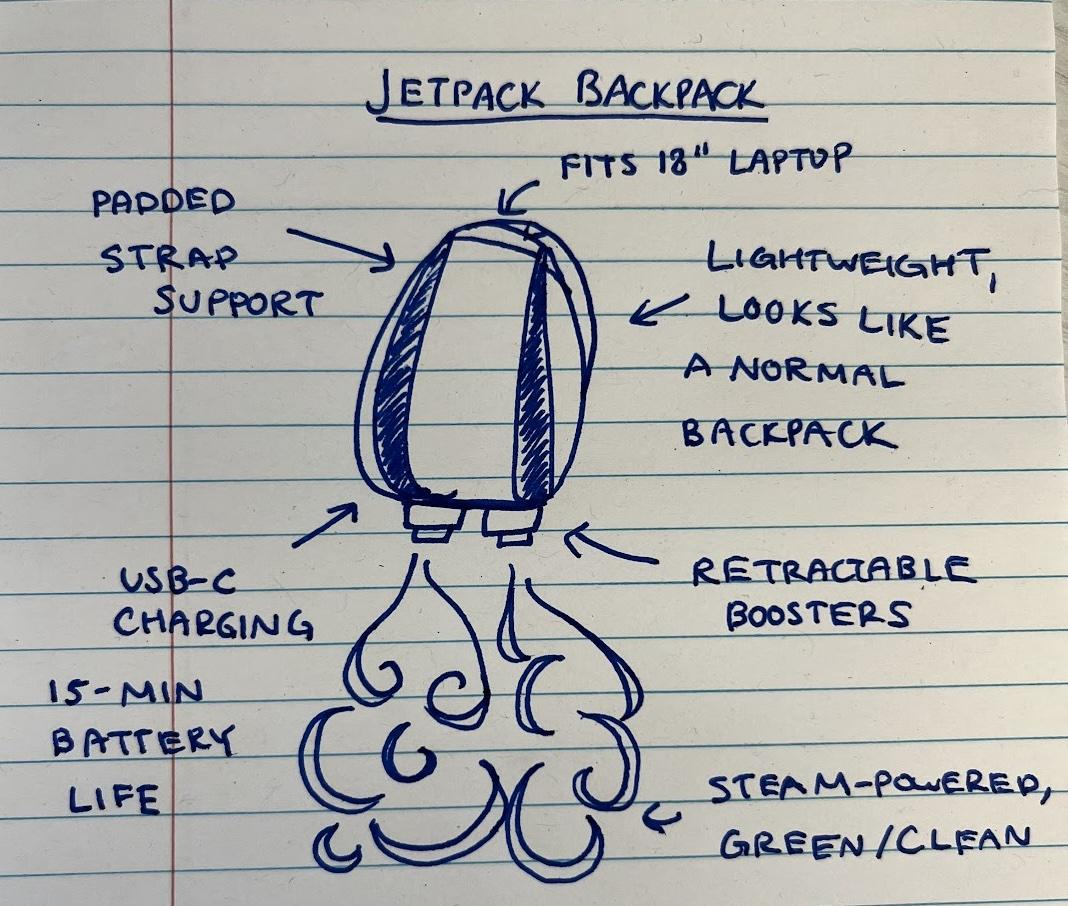

In [7]:
from IPython.display import Image

!curl -o image.jpg "https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg"
Image(filename="image.jpg")

Next, you will upload that file to the File API.

In [8]:
sample_file = client.files.upload(file="image.jpg")

print(f"Uploaded file '{sample_file.name}' as: {sample_file.uri}")

Uploaded file 'files/5djqlsrlsmw7' as: https://generativelanguage.googleapis.com/v1beta/files/5djqlsrlsmw7


The `response` shows that the File API stored the specified `display_name` for the uploaded file and a `uri` to reference the file in Gemini API calls. Use `response` to track how uploaded files are mapped to URIs.

Depending on your use cases, you could store the URIs in structures such as a `dict` or a database.

## Get file

After uploading the file, you can verify the API has successfully received the files by calling `files.get`.

It lets you get the file metadata that have been uploaded to the File API that are associated with the Cloud project your API key belongs to. Only the `name` (and by extension, the `uri`) are unique. Only use the `displayName` to identify files if you manage uniqueness yourself.

In [9]:
file = client.files.get(name=sample_file.name)
print(f"Retrieved file '{file.name}' as: {sample_file.uri}")

Retrieved file 'files/5djqlsrlsmw7' as: https://generativelanguage.googleapis.com/v1beta/files/5djqlsrlsmw7


## Generate content

After uploading the file, you can make `GenerateContent` requests that reference the file by providing the URI. In the Python SDK you can pass the returned object directly.

Here you create a prompt that starts with text and includes the uploaded image.

In [10]:
MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

response = client.models.generate_content(
    model=MODEL_ID,
    contents=["Describe the image with a creative description.", sample_file]
)

print(response.text)

On the humble canvas of lined notebook paper, rendered in a confident blue ink, lies the nascent blueprint of tomorrow's commute: the "JETPACK BACKPACK."

This isn't just a carry-all; it's a doodle of defiance, a charmingly analog vision of a future where mundane burdens meet sky-high ambitions. The backpack itself appears sleek and unassuming, looking like a "normal backpack" and promising to be "lightweight," yet engineered for comfort with "padded strap support." Practicality isn't overlooked, as it boasts the capacity to fit a hefty "18" laptop," ready for the urban professional or an adventurous student.

But below its practical form, the real magic ignites. Twin "retractable boosters" extend, exhaling elegant, swirling plumes of "steam-powered" thrust, a visual promise of "green/clean" liberation. It’s a whimsical dance of vapor against gravity, implying a gentle, eco-conscious lift. While the concept embraces modern convenience with "USB-C charging," the inventor's honest hand r

## Multiple files

You'll often want to upload multiple files at once. Here's a quick example how you can do it:

In [11]:
!git clone -q --depth 1 https://github.com/googleapis/python-genai

In [13]:
import pathlib

files = []
for p in pathlib.Path("python-genai").rglob('*.py'):
  if 'test' in str(p):
    continue
  f = client.files.upload(file=p, config={'display_name': str(p)})
  # The API doesn't see the file name, so add those to the list of parts.
  files.append(f"<<<File: {str(p)}>>>")
  files.append(f)
  print('.', end='')

..................................

In [14]:
client.models.generate_content(
    model=MODEL_ID,
    contents=["Hi, could you give me a summary of this code base?"] + files
)

GenerateContentResponse(
  automatic_function_calling_history=[],
  candidates=[
    Candidate(
      content=Content(
        parts=[
          Part(
            text="""This Python codebase provides the **Google Generative AI SDK**, designed to allow developers to interact with both the **Google Gemini API** and **Google Cloud's Vertex AI platform**. It offers a comprehensive set of tools for building generative AI applications, abstracting away the complexities of the underlying APIs.

Here's a summary of its core components and functionalities:

1.  **Client Entry Point (`client.py`)**:
    *   The `Client` class is the main entry point for synchronous interactions, and `AsyncClient` (accessed via `client.aio`) for asynchronous operations.
    *   Handles authentication (API keys, Google Cloud Application Default Credentials) and configuration (project ID, location, HTTP options), supporting both Gemini API and Vertex AI.
    *   Integrates a `ReplayApiClient` for testing, allowing

## Delete files

Files are automatically deleted after 2 days or you can manually delete them using `files.delete()`.

In [15]:
client.files.delete(name=sample_file.name)
print(f"Deleted {sample_file.name}.")

Deleted files/5djqlsrlsmw7.


## Supported text types

As well as supporting media uploads, the File API can be used to embed text files, such as Python code, or Markdown files, into your prompts.

This example shows you how to load a markdown file into a prompt using the File API.

In [16]:
# Download a markdown file and ask a question.
from google.genai import types
from IPython.display import Markdown

!curl -so contrib.md https://raw.githubusercontent.com/google-gemini/cookbook/main/CONTRIBUTING.md

md_file = client.files.upload(
    file="contrib.md",
    config={
        "display_name": "CONTRIBUTING.md",
        "mime_type": "text/markdown"
    }
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "What should I do before I start writing, when following these guidelines?",
        md_file,
    ]
)

display(Markdown(response.text))

Based on the "Contributing to the Gemini API Cookbook" guidelines, here's what you should do before you start writing:

1.  **Sign the Contributor License Agreement (CLA):** All contributions require you (or your employer) to sign a CLA. Visit [https://cla.developers.google.com/](https://cla.developers.google.com/) to check your status or sign a new one. This gives Google permission to use your contributions.
2.  **File an Issue:** **Before you write a single line**, create an issue on the GitHub repository. This is crucial for discussing your idea, getting guidance on structure, and ensuring your content has full support before you invest time in writing.
3.  **Review Style Guides:** Before you start writing, read the [technical writing style guide highlights](https://developers.google.com/style/highlights) to anticipate common feedback. Also, check the relevant [style guide](https://google.github.io/styleguide/) for the language you'll be using, especially if your content includes code fragments.

Some common text formats are automatically detected, such as `text/x-python`, `text/html` and `text/markdown`. If you are using a file that you know is text, but is not automatically detected by the API as such, you can specify the MIME type as `text/plain` explicitly.

In [17]:
# Download some C++ code and force the MIME as text when uploading.

!curl -so gemma.cpp https://raw.githubusercontent.com/google/gemma.cpp/main/examples/hello_world/run.cc

cpp_file = client.files.upload(
    file="gemma.cpp",
    config={
        "display_name":"gemma.cpp",
        "mime_type":"text/plain"
    }
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=["What does this program do?", cpp_file]
)

display(Markdown(response.text))

This C++ program is a command-line application designed to demonstrate text generation using the **Gemma large language model** with a specific feature: **constrained decoding**, which allows users to prevent certain tokens from being generated.

Here's a breakdown of what it does:

1.  **Argument Parsing:**
    *   It parses command-line arguments for:
        *   `LoaderArgs`: Related to loading the Gemma model (e.g., path to weights, tokenizer).
        *   `ThreadingArgs`: Configuration for multithreading.
        *   `InferenceArgs`: Parameters for the inference process (e.g., precision, quantization).
    *   It also checks for a `--help` flag to display usage information.

2.  **Constrained Decoding Setup (`--reject` flag):**
    *   A significant feature of this specific program is its ability to **reject certain tokens**.
    *   It looks for a `--reject` command-line flag. Any integer arguments following `--reject` are parsed and added to a `std::set<int>` called `reject_tokens`. These tokens will explicitly *not* be allowed in the model's output.

3.  **Model and Cache Initialization:**
    *   It initializes a `gcpp::ThreadingContext` and `gcpp::MatMulEnv` for efficient computation.
    *   It instantiates the `gcpp::Gemma` model using the loaded arguments.
    *   It creates a `gcpp::KVCache`, which is crucial for efficient auto-regressive text generation in large language models by storing past attention keys and values.

4.  **Prompt Definition and Tokenization:**
    *   It defines a **hardcoded prompt**: `"Write a greeting to the world."`
    *   This prompt is then tokenized into a sequence of integer IDs (`std::vector<int> tokens`) using Gemma's tokenizer, including any necessary chat templating or wrapping based on the model configuration.

5.  **Output Streaming Callback (`stream_token`):**
    *   It defines a lambda function, `stream_token`, which acts as a callback.
    *   This callback is invoked every time the model generates a new token.
    *   If the generated token is not an End-Of-Sequence (EOS) token and is part of the model's actual response (i.e., not part of the initial prompt), it decodes the token back into human-readable text and prints it immediately to `std::cout`, followed by `std::flush` to ensure real-time output.

6.  **Token Acceptance Callback (`accept_token`):**
    *   This is where the constrained decoding feature is implemented.
    *   Another lambda function is defined as the `accept_token` callback.
    *   Before a token is actually *chosen* by the model, this callback is called. It returns `true` if the token is allowed, and `false` if it should be rejected.
    *   The logic within this callback checks if the proposed token is present in the `reject_tokens` set (populated from the `--reject` command-line arguments). If the token *is found* in `reject_tokens`, it returns `false`, effectively preventing the model from generating it.

7.  **Text Generation:**
    *   It sets up a `gcpp::RuntimeConfig` specifying:
        *   `max_generated_tokens`: A limit of 1024 tokens for the response.
        *   `temperature`: Set to 1.0, controlling the randomness of the generation.
        *   `stream_token`: The callback for printing output.
        *   `accept_token`: The callback for enforcing token rejection.
    *   Finally, it calls `gemma.Generate()`, passing the `runtime_config`, the tokenized prompt, the KV cache, and other environment variables to start the text generation process.

**In summary, this program initializes a Google Gemma language model, provides it with a fixed prompt ("Write a greeting to the world."), and then generates and streams its response to the console. Its unique feature is the ability to exclude specific tokens from the model's output via command-line arguments, demonstrating a constrained decoding capability.**

## Next Steps
### Useful API references:

For more information about the File API, check its [API reference](https://ai.google.dev/api/files). You will also find more code samples [in this folder](../quickstarts/file-api).

### Related examples

Check those examples using the File API to give you more ideas on how to use that very useful feature:
* Share [Voice memos](../examples/Voice_memos.ipynb) with Gemini API and brainstorm ideas
* Analyze videos to [classify](../examples/Analyze_a_Video_Classification.ipynb) or [summarize](../examples/Analyze_a_Video_Summarization.ipynb) them

### Continue your discovery of the Gemini API

If you're not already familiar with it, learn how [tokens are counted](../quickstarts/Counting_Tokens.ipynb). Then check how to use the File API to use [Audio](../quickstarts/Audio.ipynb) or [Video](../quickstarts/Video.ipynb) files with the Gemini API.
